In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

from scipy.special import gamma
from time import time

## Auxiliary constants

In [2]:
european_call_ref = 0.056832
variance_swap_price_ref = 0.028295
variance_call_price_ref = 0.013517

In [3]:
S_n_const = "S_n"
V_n_const = "V_n"
X_n_const = "X_n"

In [29]:
M = 10**3

l = 0.3
nu = 0.3
theta = 0.02
rho = -0.7
H = 0.1

K = 1

V_0 = 0.02
S_0 = 1
Y_0 = np.log(S_0)

In [30]:
T = 1

In [31]:
number_of_iterations = 5
n_initial = 10

## Kernel

In [7]:
def K_t(t):
    #return np.log(1+1/(t+1))

    if t == 0:
        return 0
    
    return t**(H-0.5)/gamma(H+0.5)

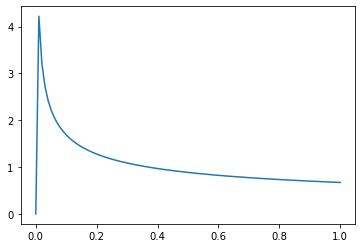

In [10]:
n = 100
t = [k*T/(n-1) for k in range(n)]
K_arr = []

for k in range(np.size(t)):
    K_arr.append(K_t(t[k]))
    
    if K_arr[k]<0:
        print(f"Problem is here: K({t[k]})={K_arr[k]}")
    
plt.plot(t, K_arr)
plt.show()

## Payoff functions

In [11]:
def european_call_options(x):
    if type(x) != np.ndarray and type(x) != list:
        raise Exception(f"type(x) != list\n type(x)={type(x)}")
        
    return np.maximum(x[-1]-K,0)

def asian_options(x):
    A_T = T*np.mean(x)
    
    return np.maximum(A_T-K,0)

def lookback_options(x):
    M_T = np.max(x)
    
    return np.maximum(M_T-K,0)

def variance_swap_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return x[-1]
        
    return x

def variance_call_price(x):
    if type(x) is np.ndarray or type(x) is list:
        return np.maximum(x[-1]-V_0,0)
        
    return np.maximum(x-V_0,0)

## Utility methods for displaying data

In [28]:
def plot_estimations(scheme_8_data, scheme_9_data, title="E[f(S,X)]", ref_value=None):
    integers1toN = scheme_8_data['n']
    
    fig, ax = plt.subplots()

    ax.plot(integers1toN, scheme_8_data['U_M'], label='Scheme (8)', color="blue")
    ax.fill_between(integers1toN, np.array(scheme_8_data['U_M']) - np.array(scheme_8_data['error']), 
                    np.array(scheme_8_data['U_M']) + np.array(scheme_8_data['error']), label='Confidence interval', 
                    color='blue', alpha=.1)
    
    ax.plot(integers1toN, scheme_9_data['U_M'], label='Scheme (9)', color="orange")
    ax.fill_between(integers1toN, np.array(scheme_9_data['U_M']) - np.array(scheme_9_data['error']), 
                    np.array(scheme_9_data['U_M']) + np.array(scheme_9_data['error']), label='Confidence interval', 
                    color='orange', alpha=.1)

    if ref_value != None:
        ax.axhline(ref_value, label='reference value', color="green", linestyle='--')
    
    ax.legend(loc=1)
    
    plt.title(f"Estimation of {title}")
    plt.xlabel("Number of steps")
    plt.ylabel("Estimation")
    
    plt.show()

    
def show_numerical_results_table(scheme_8_results, scheme_9_results, ref_value=None):
    table_size = np.size(scheme_8_results['U_M'])
    
    print("\tEstimation of E[f] with Scheme (8) (left) and Scheme (9) (right). The computation time is in seconds.")
    print()
    print("\tMean Value\t Stat.Error\t Comp.Time\t||\t Mean Value\t Stat.Error\t Comp.Time")
    
    if ref_value != None:
        print(f"Ref\t {ref_value}")
        print()
        
    for k in range(table_size):
        print(f"n={scheme_8_results['n'][k]}\t",
            f"{scheme_8_results['U_M'][k]:f}\t",
            f"{scheme_8_results['error'][k]:f}\t",
            f"{scheme_8_results['time'][k]:f}\t||\t",
            f"{scheme_9_results['U_M'][k]:f}\t",
            f"{scheme_9_results['error'][k]:f}\t",
            f"{scheme_9_results['time'][k]:f}")


In [13]:
def stats_n(data):

    U_M = np.mean(data)
    var_M = np.var(data)
    
    error = 2*var_M/np.sqrt(M)
    confidence_interval = [U_M - error, U_M + error]

    return {"U_M": U_M,
            "var_M": var_M,
            "error": error,
            "confidence_interval": confidence_interval}

In [14]:
def generate_subdivision(t):

    t_size = np.size(t)
    t_temp = t
    
    for k in range(0,t_size-1):
        t = np.insert(t,2*k+1,(t_temp[k+1]+t_temp[k])/2)
        
    return t

def generate_BM(t,W,W_orth,n=n_initial):

    if np.size(W)==0 or np.size(W_orth)==0:
        if np.size(t) != n:
            raise Exception(f"np.size(t) != n_initial\n np.size(t)={np.size(t)},n_initial={n}")
            
        G1 = np.random.randn(n)
        G2 = np.random.randn(n)
        
        W.append(0)
        W_orth.append(0)
        
        for i in range(n-1):
            W.append(W[i] + np.sqrt(t[i+1] - t[i])*np.random.normal(0,1))
            W_orth.append(W_orth[i] + np.sqrt(t[i+1] - t[i])*np.random.normal(0,1))
        
        return W, W_orth

    W_temp = W
    W_orth_temp = W_orth
    
    N = np.size(t)
    
    for i in range(1,N,2):
        
        var = (t[i+1] - t[i-1])/4
        W_k = np.random.normal((W[i-1]+W[i])/2, np.sqrt(var))
        W_orth_k = np.random.normal((W_orth[i-1]+W_orth[i])/2, np.sqrt(var))
        
        W_temp.insert(i,W_k)
        W_orth_temp.insert(i,W_orth_k)

    return W_temp, W_orth_temp

### Validity of Brownian motion & Brownian bridge

We check the convergence of variance of increments of Brownian motion.

### Brownian motion demo

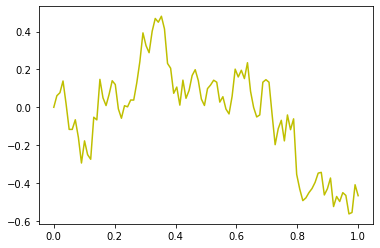

In [15]:
n_test = 100
t_test = [k*T/(n_test-1) for k in range(n_test)]
w, _ = generate_BM(t_test,[],[],n_test)

plt.plot(t_test, w, color="y")
plt.show()

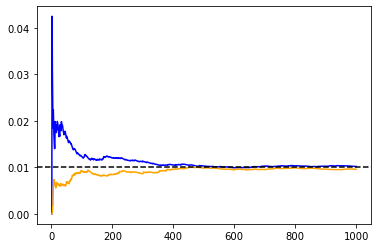

In [16]:
n_test = 100
t_test = [k*T/(n_test-1) for k in range(n_test)]
bm = 10**3

e1 = []
e2 = []

for m in range(bm):
    w1, w2 = generate_BM(t_test,[],[],n_test)
    
    e1.append(w1[-1]-w1[-2])
    e2.append(w2[-1]-w2[-2])

bm_range = np.arange(1,bm+1)

t_delta = t_test[1]-t_test[0]

var1 = np.cumsum(np.power(e1,2))/bm_range-(np.cumsum(e1)/bm_range)**2
var2 = np.cumsum(np.power(e2,2))/bm_range-(np.cumsum(e2)/bm_range)**2

plt.plot(bm_range, var1, color="blue")
plt.plot(bm_range, var2, color="orange")

plt.axhline(t_delta, color="black", linestyle='--')
plt.show()

### Brownian bridge demo

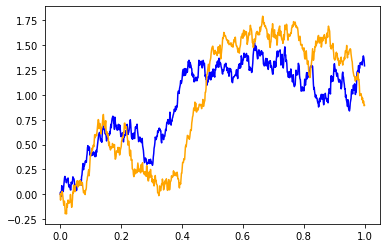

In [17]:
n_test = 7
t_test = [k*T/(n_test-1) for k in range(n_test)]

w1, w2 = generate_BM(t_test,[],[],n_test)

for i in range(n_test):
    t_test = generate_subdivision(t_test)
    w1, w2 = generate_BM(t_test,w1,w2)

plt.plot(t_test, w1, color="blue")
plt.plot(t_test, w2, color="orange")
plt.show()

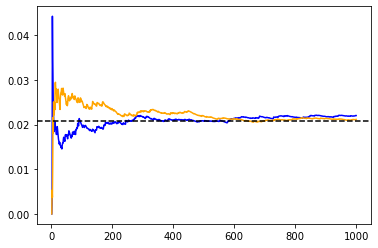

In [18]:
n_test = 4
n = 4

bm = 10**3

e1 = []
e2 = []

for m in range(bm):
    t_test = [k*T/(n_test-1) for k in range(n_test)]
    w1, w2 = generate_BM(t_test,[],[],n_test)

    for i in range(4):

        t_test=generate_subdivision(t_test)
        w1, w2 = generate_BM(t_test,w1,w2)
        
    e1.append(w1[-1]-w1[-2])
    e2.append(w2[-1]-w2[-2])

bm_range = np.arange(1,bm+1)

t_delta = t_test[1]-t_test[0]

var1 = np.cumsum(np.power(e1,2))/bm_range-(np.cumsum(e1)/bm_range)**2
var2 = np.cumsum(np.power(e2,2))/bm_range-(np.cumsum(e2)/bm_range)**2

plt.plot(bm_range, var1, color="blue")
plt.plot(bm_range, var2, color="orange")

plt.axhline(t_delta, color="black", linestyle='--')
plt.show()

# Main algorithms

## Euler scheme for (S,V) process

In [34]:
def S_V_process(t,W,W_orth):

    n = np.size(t)

    Y_n = np.zeros(n)
    V_n = np.zeros(n)
    S_n = np.zeros(n)

    S_n[0] = S_0
    Y_n[0] = Y_0
    V_n[0] = V_0

    t_delta = t[1] - t[0]

    for k in range(1,n):

        V_sum = 0
        for i in range(k):
            v_max = np.maximum(V_n[i],0)
            V_sum += ((K_t(t[k]-t[i])*(-l*v_max*t_delta
                     + nu*np.sqrt(v_max)*(W[i+1] - W[i]))))
            
            #V_sum += ((K_t(t[k]-t[i])*((theta - l*v_max)*t_delta
            #         + nu*np.sqrt(v_max)*(W[i+1] - W[i]))))

        K_integral = integrate.quad(lambda s: theta*K_t(t[k]-s), 0, t[k])[0]
        V_n[k] = V_0 + V_sum + K_integral

        Y_sum = 0
        for i in range(k):
            v_max = np.maximum(V_n[i],0)
            Y_sum += (-0.5*v_max*t_delta + rho*np.sqrt(v_max)*(W[i+1] - W[i]) 
                  + np.sqrt(1 - rho**2)*np.sqrt(v_max)*(W_orth[i+1] - W_orth[i]))

        Y_n[k] = Y_0 + Y_sum
        S_n[k] = np.exp(Y_n[k])


    return {"V_n": V_n,
            "S_n": S_n}


## Euler scheme for (S,X) process

In [35]:
def S_X_process(t,Z,Z_orth):
    
    n = np.size(t)
    
    Y_n = np.zeros(n)
    X_n = np.zeros(n)
    X_n_max = np.zeros(n)
    
    S_n = np.zeros(n)

    M_n = np.zeros(n)
    M_n_orth = np.zeros(n)

    Y_n[0] = Y_0
    S_n[0] = S_0
   
    t_delta = t[1] - t[0]
        
    for k in range(n):

        X_sum = 0
        for i in range(k):
            #X_sum += (theta*t[i] - l*X_n_max[i] + nu*M_n[i])*t_delta*K_t(t[k] - t[i])
            X_sum += (-l*X_n_max[i] + nu*M_n[i])*t_delta*K_t(t[k] - t[i])

        K_integral = integrate.quad(lambda s: theta*s*K_t(t[k]-s), 0, t[k])[0]
        
        X_n[k] = V_0*t[k] + X_sum + K_integral
        X_n_max[k] = np.max(X_n)

        for i in range(1,k+1):
            M_n[k] += np.sqrt(X_n_max[i] - X_n_max[i-1])*Z[i]
            M_n_orth[k] += np.sqrt(X_n_max[i] - X_n_max[i-1])*Z_orth[i]
        
        Y_n[k] = Y_0 - 0.5*X_n_max[k] + rho*M_n[k] + np.sqrt(1 - rho**2)*M_n_orth[k]
        S_n[k] = np.exp(Y_n[k])
        
        
    return {"S_n": S_n,
            "X_n": X_n}


## Evaluation algorithms

In [36]:
def scheme_8(f, variable, n=None):

    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    W_M = [0]*M
    W_orth_M = [0]*M

    for m in range(M):
        W, W_orth = generate_BM(t,[],[],N)

        W_M[m] = W
        W_orth_M[m] = W_orth
 
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}
    evaluate = None
    
    for n in range(iterations):

        t_0 = time()

        t_delta = t[1]-t[0]

        f_n_M = np.zeros(M)

        for m in range(M):

            result_sv = S_V_process(t,W_M[m],W_orth_M[m])

            S_n = result_sv["S_n"]
            V_n = result_sv["V_n"]
            X_n = sum(V_n)*t_delta
            
            if variable == S_n_const:
                evaluate = S_n
            elif variable == V_n_const:
                evaluate = V_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)

            t_new = generate_subdivision(t)
            W_M[m], W_orth_M[m] = generate_BM(t_new,W_M[m],W_orth_M[m])

        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))

        t = generate_subdivision(t)

    return final_result

In [37]:
def generate_Z(n, Z, Z_orth):
        
    if n == np.size(Z):
        return Z, Z_orth
    
    if np.size(Z) == 0 or np.size(Z_orth) == 0:
        Z = np.random.normal(0,1,n)
        Z_orth = np.random.normal(0,1,n)
        
        return Z, Z_orth

    for i in range(1,n,2):
        Z = np.insert(Z, i, np.random.normal(0,1))
        Z_orth = np.insert(Z_orth, i, np.random.normal(0,1))        
        
    return Z, Z_orth

def scheme_9(f, variable, n=None):
    
    iterations = number_of_iterations
    N = n_initial
    
    if n != None:
        iterations = 1
        N = n
        
    t = [k*T/(N-1) for k in range(N)]

    Z_M = [0]*M
    Z_orth_M = [0]*M

    for m in range(M):
        Z, Z_orth = generate_Z(np.size(t),[],[])

        Z_M[m] = Z
        Z_orth_M[m] = Z_orth
        
    final_result = {key: [] for key in ["U_M","n","time","var_M","confidence_interval","error","cum_sum_n"]}

    evaluate = None
        
    for n in range(iterations):

        t_0 = time()

        f_n_M = np.zeros(M)
        
        for m in range(M):
            result_sv = S_X_process(t,Z_M[m],Z_orth_M[m])

            S_n = result_sv["S_n"]
            X_n = result_sv["X_n"]

            if variable == S_n_const:
                evaluate = S_n
            elif variable == X_n_const:
                evaluate = X_n
            else:
                raise Exception(f"Wrong variable call: {variable}")

            f_n_M[m] = f(evaluate)
            
            Z_M[m], Z_orth_M[m] = generate_Z(2*np.size(t)-1,Z_M[m],Z_orth_M[m])
        
        t_1 = time()
        
        n_result = stats_n(f_n_M)

        final_result["U_M"].append(n_result["U_M"])
        final_result["error"].append(n_result["error"])
        final_result["var_M"].append(n_result["var_M"])
        final_result["confidence_interval"].append(n_result["confidence_interval"])
        final_result["time"].append(t_1 - t_0)
        final_result["n"].append(np.size(t))
        
        t = generate_subdivision(t)

    return final_result

# Numerical experiments

## _European call_ maximum(S_T-K,0)

In [ ]:
scheme_8_results = scheme_8(european_call_options, S_n_const)
scheme_9_results = scheme_9(european_call_options, S_n_const)

In [ ]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(S_T-K,0)]")
show_numerical_results_table(scheme_8_results ,scheme_9_results, european_call_ref)

## _Asian option_ maximum(A_T-K,0)

In [ ]:
scheme_8_results = scheme_8(asian_options, S_n_const)
scheme_9_results = scheme_9(asian_options, S_n_const)

In [ ]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(A_T-K,0)]") 
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Lookback option_ maximum(M_T-K,0)


In [ ]:
scheme_8_results = scheme_8(lookback_options, S_n_const)
scheme_9_results = scheme_9(lookback_options, S_n_const)

In [ ]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(M_T-K,0)]")
show_numerical_results_table(scheme_8_results, scheme_9_results, "-")

## _Variance swap price_ E[X_t]

In [ ]:
scheme_8_results = scheme_8(variance_swap_price, X_n_const)
scheme_9_results = scheme_9(variance_swap_price, X_n_const)

In [ ]:
plot_estimations(scheme_8_results, scheme_9_results, "E[X_T]", variance_swap_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_swap_price_ref)

## _Variance call price_ E[maximum(X_T-V_0,0)]

In [ ]:
scheme_8_results = scheme_8(variance_call_price, X_n_const)
scheme_9_results = scheme_9(variance_call_price, X_n_const)

In [ ]:
plot_estimations(scheme_8_results, scheme_9_results, "E[maximum(X_T-V_0,0)]", variance_call_price_ref)
show_numerical_results_table(scheme_8_results, scheme_9_results, variance_call_price_ref)

## Results for fixed n

In [ ]:
n = 320

print(f"n = {n}")
print()
print("Payoff function\t\t||\t Scheme 1\t||\t Scheme 2\t||\t Difference")    
print()

european_call_options_8_results = scheme_8(european_call_options, S_n_const, n)
european_call_options_9_results = scheme_9(european_call_options, S_n_const, n)

print(f"European call\t\t||\t",
    f"{european_call_options_8_results['U_M'][0]:f}\t||\t",
    f"{european_call_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(european_call_options_8_results['U_M'][0]-european_call_options_9_results['U_M'][0]):f}\t") 

asian_options_8_results = scheme_8(asian_options, S_n_const, n)
asian_options_9_results = scheme_9(asian_options, S_n_const, n)

print(f"Asion call\t\t||\t",
    f"{asian_options_8_results['U_M'][0]:f}\t||\t",
    f"{asian_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(asian_options_8_results['U_M'][0]-asian_options_9_results['U_M'][0]):f}\t") 

lookback_options_8_results = scheme_8(lookback_options, S_n_const, n)
lookback_options_9_results = scheme_9(lookback_options, S_n_const, n)

print(f"Lookback call\t\t||\t",
    f"{lookback_options_8_results['U_M'][0]:f}\t||\t",
    f"{lookback_options_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(lookback_options_8_results['U_M'][0]-lookback_options_9_results['U_M'][0]):f}\t") 

variance_swap_price_8_results = scheme_8(variance_swap_price, X_n_const, n)
variance_swap_price_9_results = scheme_9(variance_swap_price, X_n_const, n)

print(f"Variance swap call\t||\t",
    f"{variance_swap_price_8_results['U_M'][0]:f}\t||\t",
    f"{variance_swap_price_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(variance_swap_price_8_results['U_M'][0]-variance_swap_price_9_results['U_M'][0]):f}\t") 

variance_call_price_8_results = scheme_8(variance_call_price, X_n_const, n)
variance_call_price_9_results = scheme_9(variance_call_price, X_n_const, n)

print(f"Variance call\t\t||\t",
    f"{variance_call_price_8_results['U_M'][0]:f}\t||\t",
    f"{variance_call_price_9_results['U_M'][0]:f}\t||\t",
    f"{np.abs(variance_call_price_8_results['U_M'][0]-variance_call_price_9_results['U_M'][0]):f}\t")